In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pmdarima.arima import auto_arima
import yfinance as yf

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [20]:
# Define the ticker symbol
ticker_symbol = 'AAPL'  # Example: Apple Inc.

# Fetch historical stock price data using yfinance
stock_data = yf.download(ticker_symbol, start='2010-01-01', end='2019-12-31')

[*********************100%***********************]  1 of 1 completed


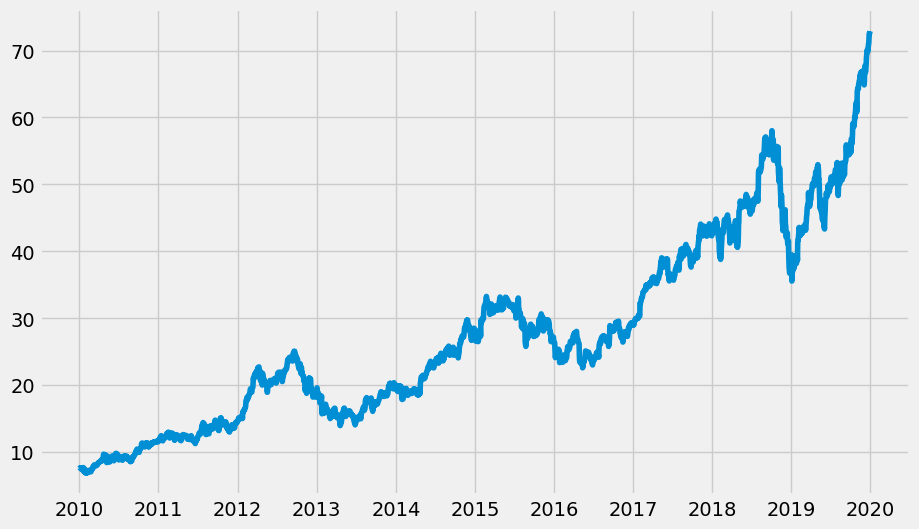

In [21]:
plt.plot(stock_data.Close)

In [22]:
data_training = pd.DataFrame(stock_data['Close'][0:int(len(stock_data)*0.70)])
data_testing = pd.DataFrame(stock_data['Close'][int(len(stock_data)*0.70):int(len(stock_data))])

print(data_training.shape)
print(data_testing.shape)

(1761, 1)
(755, 1)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1145.529, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1146.878, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1146.844, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1145.908, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1148.574, Time=2.84 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 4.779 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1761
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -570.764
Date:                Sun, 21 Apr 2024   AIC                           1145.529
Time:                        01:30:19   BIC                           1156.475
Sample:                             0   HQIC                          1149.574
                               - 1761                                       

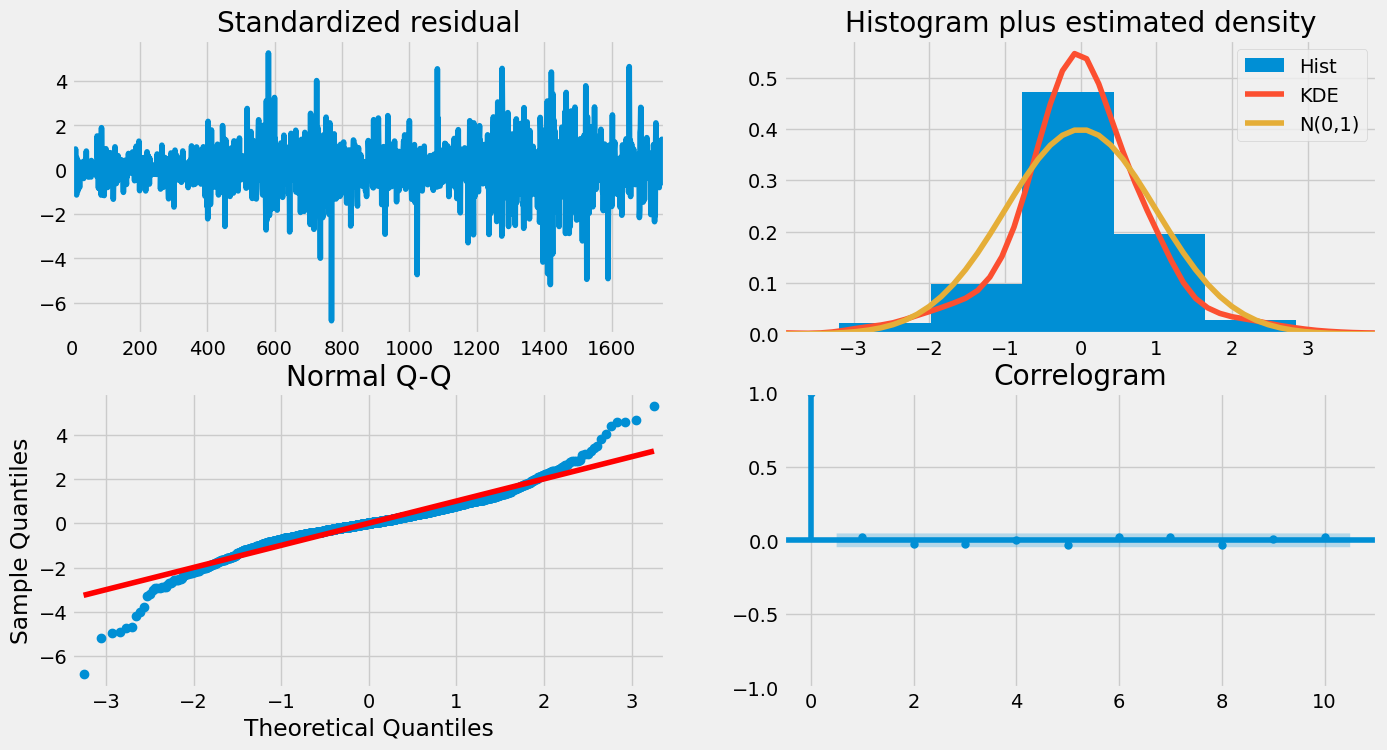

In [23]:
model_autoARIMA = auto_arima(data_training, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [24]:
#Modeling
# Build Model
# model = ARIMA(data_training, order=(1,1,2))  
# fitted = model.fit()  

model = sm.tsa.arima.ARIMA(data_training, order=(1,1,2))
result = model.fit()

print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1761
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -570.716
Date:                Sun, 21 Apr 2024   AIC                           1149.433
Time:                        01:30:21   BIC                           1171.325
Sample:                             0   HQIC                          1157.523
                               - 1761                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5159      0.464      1.113      0.266      -0.393       1.424
ma.L1         -0.4958      0.466     -1.064      0.287      -1.409       0.417
ma.L2         -0.0370      0.019     -1.937      0.0

In [28]:
pred = result.forecast(755, alpha=0.05)  # 95% conf

pred = pred.to_frame()

In [29]:
data_testing['predicted_mean'] = pred['predicted_mean'].values

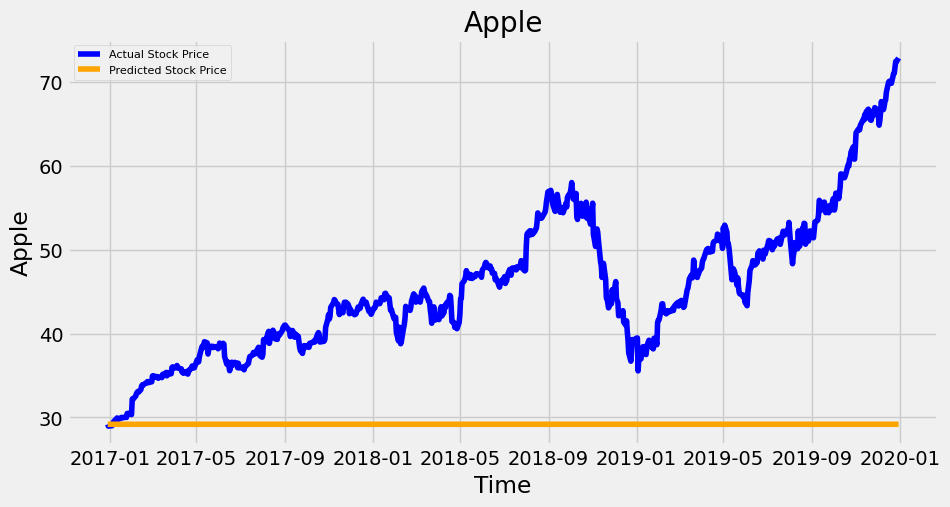

In [30]:
plt.figure(figsize=(10,5), dpi=100)
# plt.plot(data_training, label='training data')
plt.plot(data_testing["Close"], color = 'blue', label='Actual Stock Price')
plt.plot(data_testing["predicted_mean"], color = 'orange',label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('Apple')
plt.xlabel('Time')
plt.ylabel('Apple')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [32]:
mae = np.mean(np.abs(data_testing["predicted_mean"] - data_testing["Close"]))

# Calculate the range of the target variable
target_range = np.max(data_testing["Close"]) - np.min(data_testing["Close"])

# Calculate the error percentage
error_percentage = (mae / np.mean(data_testing["Close"])) * 100

print(f"Error Percentage: {error_percentage:.2f}%")

Error Percentage: 35.98%
